In [1]:
from functools import partial
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
from chainconsumer import ChainConsumer
from scipy.optimize import curve_fit
import seaborn as sns
from emcee import EnsembleSampler
from anstey.generate import T_CMB
import src.beam_functions as BF
import src.spherical_harmonics as SH
import src.forward_model as FM
import src.sky_models as SM
import src.map_making as MM
import src.plotting as PL
import nregions_inference as NRI
from src.blockmat import BlockMatrix, BlockVector
from anstey.generate import T_CMB

RS = SH.RealSphericalHarmonics()

In [8]:
chain = np.load('saves/Binwise/Nant<4>_Npoly<12>_chrom<3.4e-02>_mcmcChain.npy')
c = ChainConsumer()
c.add_chain(chain[:,-3:])

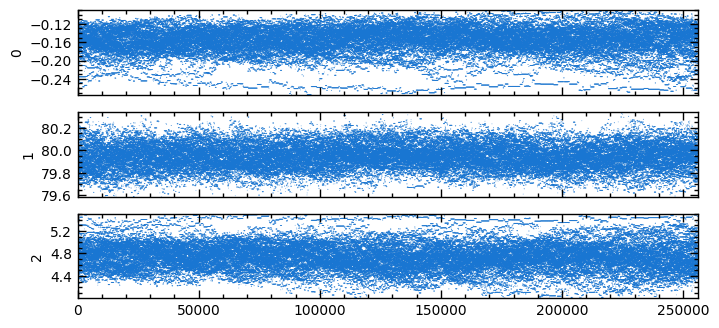

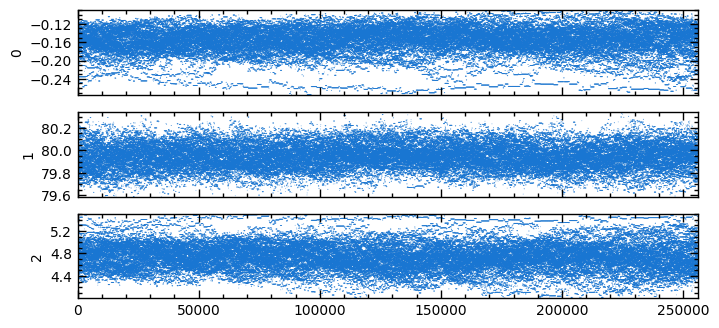

In [9]:
c.plotter.plot_walks()

In [14]:
# Observe the 21-cm sky and foregrounds in a single time bin.
nside   = 32
lmax    = 32
Nlmax   = RS.get_size(lmax)
lats = np.array([-26*2, -26, 26, 26*2])
times = np.linspace(0, 24, 12, endpoint=False)
Ntau  = 1
nuarr = np.linspace(50,100,51)
cm21_params = [-0.2, 80.0, 5.0]

# Generate foreground and 21-cm alm
fg_alm   = SM.foreground_gsma_alm_nsidelo(nu=nuarr, lmax=lmax, nside=nside, use_mat_Y=True)
cm21_alm = SM.cm21_gauss_mon_alm(nu=nuarr, lmax=lmax, params=cm21_params)
fid_alm  = fg_alm + cm21_alm

# Generate observation matrix
narrow_cosbeam = lambda x: BF.beam_cos(x, 0.8)
mat_A = FM.calc_observation_matrix_multi_zenith_driftscan(nside, lmax, Ntau=Ntau, lats=lats, times=times, beam_use=narrow_cosbeam, return_mat=False)
mat_A = BlockMatrix(mat=mat_A, mode='block', nblock=len(nuarr))

# Observe and gen noise
d = mat_A @ fid_alm
dnoisy, noise_covar = SM.add_noise(d, nuarr[1]-nuarr[0], Ntau, t_int=10000, seed=124)
derr = np.sqrt(noise_covar.diag)

# Fit the thing
Npoly=6
def mod(theta):
    theta_fg = theta[:-3]
    theta_21 = theta[-3:]
    fg_bit = np.sum([th*np.log(nuarr/60)**i for i, th in enumerate(theta_fg)], axis=0)
    cm21_bit = SM.cm21_globalT(nuarr, *theta_21)
    return np.exp(fg_bit)+cm21_bit+T_CMB

def mod_cf(nuarr, *theta):
    theta = np.array(theta)
    return mod(theta)

# Try curve_fit, if it doesn't work just set res to the guess parameters.
p0 = [10, -2.5]
p0 += [0.01]*(Npoly-2)
p0 += [-0.2, 80.0, 5.0]

res = curve_fit(mod_cf, nuarr, dnoisy.vector, p0=p0, sigma=np.sqrt(noise_covar.diag))

priors =[
    [1,25],
    [-3.5,-1.5]
]

priors += [[-10, 10.1]]*(Npoly-2)
priors += [[-0.5, -0.01], [60, 90], [1, 8]]
priors = np.array(priors)
ndim = len(priors)
nwalkers = 32

pos = res[0]*(1 + 1e-4*np.random.randn(nwalkers, ndim))
sampler = EnsembleSampler(nwalkers, ndim, NRI.log_posterior, 
                            args=(dnoisy.vector, derr, mod, priors))
_=sampler.run_mcmc(pos, nsteps=30000, progress=True, skip_initial_state_check=True)
chain_mcmc = sampler.get_chain(flat=True, discard=10000)
    


successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30000/30000 [01:23<00:00, 361.26it/s]


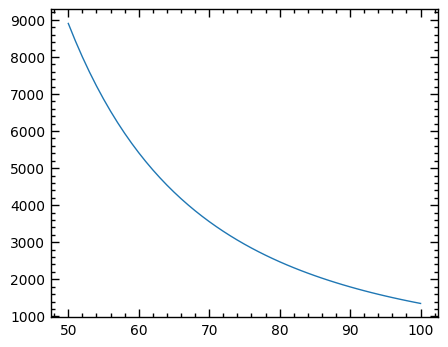

In [15]:
plt.plot(nuarr, mod(res[0]))

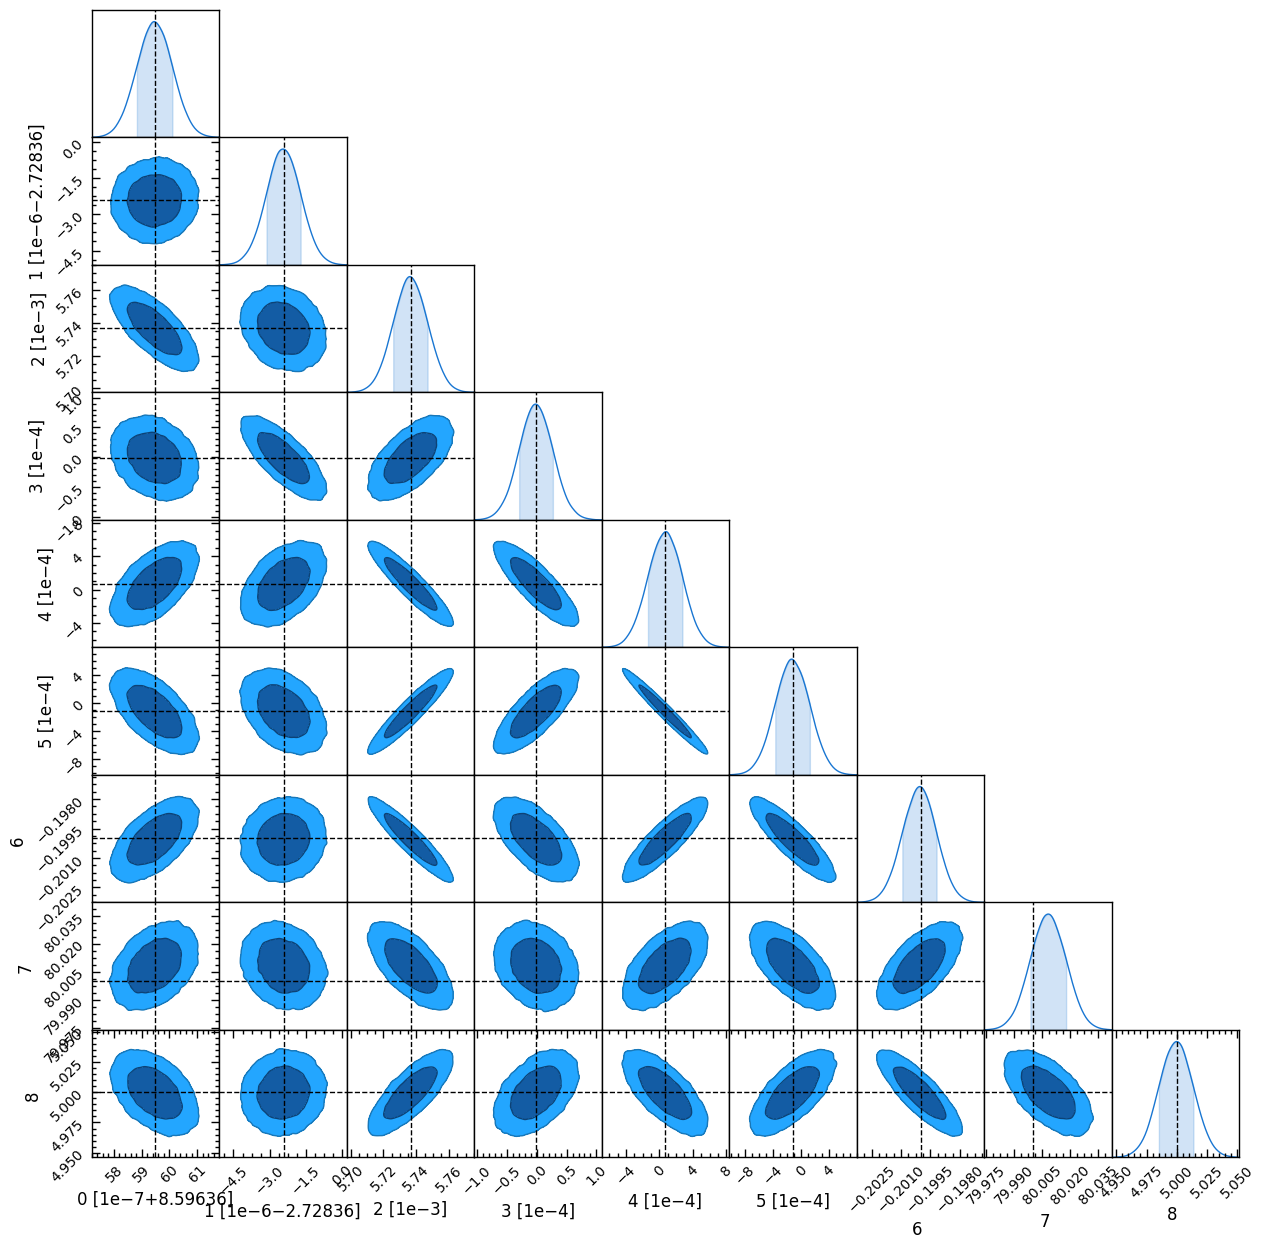

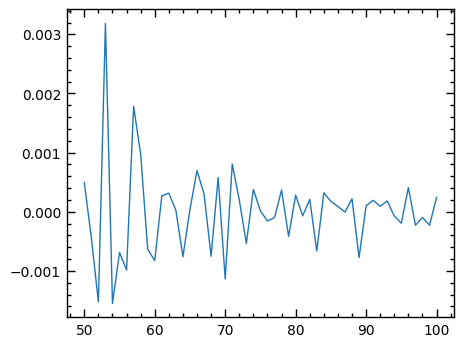

In [16]:
c=ChainConsumer()
c.add_chain(chain_mcmc)
truth = np.mean(chain_mcmc, axis=0)[:-3]
truth = np.append(truth, cm21_params)
f=c.plotter.plot(truth=truth)
plt.show()
plt.plot(nuarr, dnoisy.vector-mod(np.mean(chain_mcmc, axis=0)))